In [1]:
#John's
import numpy as np
import tensorflow as tf
import os
import time
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from datetime import datetime
import statistics as stat
import ROOT
now = datetime.utcnow().strftime("%y%m%d%H%M%S")

2023-08-11 01:20:25.996473: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.3-6fa5c/x86_64-centos7-gcc11-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.3-c1d8e/x86_64-centos7-gcc11-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_103swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/jaxlib/mlir/_mlir_libs:/cvmfs/sft.cern.ch/lcg/views/LCG_103swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_103swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/onnxruntime/capi/:/cvmfs/sft.cern.ch/lcg/views/LCG_103swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_103swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorflow/contrib

Welcome to JupyROOT 6.28/00


In [2]:
#Mine
import uproot
import pandas as pd
# import numpy as np
import boost_histogram as bh
# import matplotlib.pyplot as plt
import pickle
import gc
import atlasplots as ap
%matplotlib inline

In [123]:
version = 'full_v02'
conv = 'unconv'
size = '.5mil'
first = 500000   #first ____ events that were used for training. should = size
stand = False
weightstr = 'finalWeight'

#-------------------------------------------------------------------------------------------------------------

if stand == False:
    standstr = 'nonstand'
elif stand == True:
    standstr = ''

nameofmodel_even = 'fclass_'+version+conv+'_'+size+standstr+'_even'
nameofmodel_odd = 'fclass_'+version+conv+'_'+size+standstr+'_odd'

In [124]:
with open('TRAININGTEST/models/'+nameofmodel_even+'.json') as file:
    f_even = tf.keras.models.model_from_json(file.read())

with open('TRAININGTEST/models/'+nameofmodel_odd+'.json') as file:
    f_odd = tf.keras.models.model_from_json(file.read())

In [125]:
f_even.load_weights('TRAININGTEST/models/'+nameofmodel_even+'.h5')
f_odd.load_weights('TRAININGTEST/models/'+nameofmodel_odd+'.h5')

In [126]:
df_ea = pickle.load(open('TRAININGTEST/data/'+version+'_e'+conv[0]+'2mil_a.pickle', 'rb'))   #even
df_ez = pickle.load(open('TRAININGTEST/data/'+version+'_e'+conv[0]+'2mil_z.pickle', 'rb'))
df_oa = pickle.load(open('TRAININGTEST/data/'+version+'_o'+conv[0]+'2mil_a.pickle', 'rb'))
df_oz = pickle.load(open('TRAININGTEST/data/'+version+'_o'+conv[0]+'2mil_z.pickle', 'rb'))   #odd

In [127]:
# #IF WANT TO PREDICT ON WHOLE 4mil EVENTS FROM a AND z FILES
# df_even = pd.concat([df_ea,df_ez])
# df_odd = pd.concat([df_oa,df_oz])
# del df_ea
# del df_ez
# del df_oa
# del df_oz
# gc.collect()

In [128]:
#IF WANT 'TRAIN' AND 'TEST' PREDICTIONS TO BE JUST EVENTS TRAINED/TESTED ON  (only <size> each, like in NNtraining.py)
df_even = df_ea[:first]
df_odd = df_oa[:first]
del df_ea
del df_ez
del df_oa
del df_oz
gc.collect()

53534

In [129]:
features_stand = ['HadLeakage_stand', 'y_Reta_stand', 'y_Rphi_stand', 'y_weta2_stand',
                   'y_wtots1_stand', 'y_weta1_stand', 'y_fracs1_stand', 'y_deltae_stand',
                   'y_Eratio_stand', 'y_f1_stand']
features = ['HadLeakage', 'y_Reta', 'y_weta2', 'y_Rphi', 'y_wtots1', 
            'y_weta1', 'y_fracs1', 'y_deltae', 'y_Eratio', 'y_f1']

In [130]:
if stand == True:
    featlist = features_stand
elif stand == False:
    featlist = features

In [131]:
features_even_train = np.array(df_even[featlist])
labels_even_train   = np.array(df_even['y_isTruthMatchedPhoton'])
weights_even_train  = np.array(df_even[weightstr])
features_odd_train = np.array(df_odd[featlist])
labels_odd_train   = np.array(df_odd['y_isTruthMatchedPhoton'])
weights_odd_train  = np.array(df_odd[weightstr])

features_even_test = features_odd_train
labels_even_test = features_odd_train
weights_even_test = features_odd_train
features_odd_test = features_even_train
labels_odd_test = features_even_train
weights_odd_test = features_even_train

In [132]:
y_pred_testeven = f_even.predict(features_even_test).ravel()   #predicting the odd events (even test), using the even model


In [133]:
y_pred_testodd = f_odd.predict(features_odd_test).ravel()    #predicting the even events (odd test), using the odd model

In [134]:
y_pred_traineven = f_even.predict(features_even_train).ravel()   #"predicting" the even, using the even model


In [135]:
y_pred_trainodd = f_odd.predict(features_odd_train).ravel()    #"predicting" the odd, using the odd model

In [136]:
df_all = pd.concat([df_even,df_odd])
y_pred_test = np.concatenate((y_pred_testodd,y_pred_testeven))   #TESTODD means even events, TESTEVEN means odd events
y_pred_train = np.concatenate((y_pred_traineven,y_pred_trainodd))

df_all['y_pred_test'] = y_pred_test
df_all['y_pred_train'] = y_pred_train

In [17]:
TightIDtuple = (0.9125338241031228, 0.7782203268877278)
TightIDtuple = (0.9498026, 0.7725793)

In [18]:
# fprID,tprID,threshID = roc_curve(labels,df_all.y_IsTight.ravel()*1,sample_weight=weights)
# 1-fprID,tprID

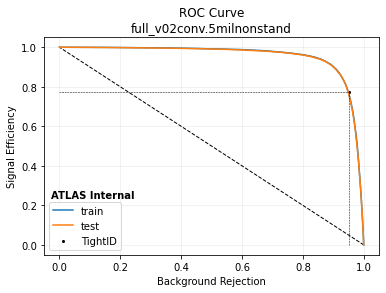

In [19]:
labels = df_all.y_isTruthMatchedPhoton.ravel()
weights = df_all.finalWeight.ravel()

#SWITCH IF DONT HAVE TIGHT ID IN DATAFRAMES
fprID,tprID,threshID = roc_curve(labels,df_all.y_IsTight.ravel()*1,sample_weight=weights)
# fprID=[0,1-TightIDtuple[0]];tprID=[0,TightIDtuple[1]]

fpr_test, tpr_test, thresholds_test = roc_curve(labels,y_pred_test,sample_weight = weights)
fpr_train, tpr_train, thresholds_train = roc_curve(labels,y_pred_train,sample_weight = weights)
plt.plot([1,0],[0,1],'k--',linewidth=1)
plt.plot(1-fpr_train, tpr_train,label='train')
plt.plot(1-fpr_test, tpr_test,label='test')
plt.scatter(1-fprID[1],tprID[1],label='TightID',c='k',s=4)
plt.plot([0,1-fprID[1]],[tprID[1],tprID[1]],'k--',linewidth=.5)
plt.plot([1-fprID[1],1-fprID[1]],[0,tprID[1]],'k--',linewidth=.5)

plt.grid(alpha=0.2)
plt.xlabel('Background Rejection')
plt.ylabel('Signal Efficiency')
plt.title('ROC Curve\n'+version+conv+size+standstr);plt.legend()
plt.text(0.11, 0.25, 'ATLAS Internal', weight='bold',horizontalalignment='center', verticalalignment='center')
plt.savefig('plots/ROC/'+version+conv+size+standstr+'_ROC.png',dpi=360,format='png')
plt.show()
plt.close()

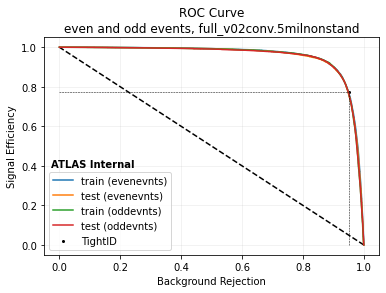

In [20]:
lab1 = df_even.y_isTruthMatchedPhoton.ravel()
lab2 = df_odd.y_isTruthMatchedPhoton.ravel()
weights1 = df_even.finalWeight.ravel()
weights2 = df_odd.finalWeight.ravel()


fprID1,tprID1,threshID1 = roc_curve(lab1,df_even.y_IsTight.ravel()*1,sample_weight=weights1)
fprID2,tprID2,threshID2 = roc_curve(lab2,df_odd.y_IsTight.ravel()*1,sample_weight=weights2)


fpr_test, tpr_test, thresholds_test = roc_curve(lab1,y_pred_testodd,sample_weight = weights1)
fpr_train, tpr_train, thresholds_train = roc_curve(lab1,y_pred_traineven,sample_weight = weights1)
fpr_test2, tpr_test2, thresholds_test2 = roc_curve(lab2,y_pred_testeven,sample_weight = weights2)
fpr_train2, tpr_train2, thresholds_train2 = roc_curve(lab2,y_pred_trainodd,sample_weight = weights2)
plt.plot([1,0],[0,1],'k--')
plt.plot(1-fpr_train, tpr_train,label='train (evenevnts)')
plt.plot(1-fpr_test, tpr_test,label='test (evenevnts)')
plt.plot(1-fpr_train2, tpr_train2,label='train (oddevnts)')
plt.plot(1-fpr_test2, tpr_test2,label='test (oddevnts)')
plt.scatter(1-fprID[1],tprID[1],label='TightID',c='k',s=4)
plt.plot([0,1-fprID[1]],[tprID[1],tprID[1]],'k--',linewidth=.5)
plt.plot([1-fprID[1],1-fprID[1]],[0,tprID[1]],'k--',linewidth=.5)

plt.grid(alpha=.2)
plt.xlabel('Background Rejection')
plt.ylabel('Signal Efficiency')
plt.title('ROC Curve\neven and odd events, '+version+conv+size+standstr);plt.legend()
plt.text(0.11, 0.41, 'ATLAS Internal', weight='bold',horizontalalignment='center', verticalalignment='center')
plt.savefig('plots/ROC/'+version+conv+size+standstr+'_ROCeo.png',dpi=360,format='png')
plt.show()
plt.close()

In [21]:
df_all.columns

Index(['mcTotWeight', 'goodWeight', 'finalWeight', 'y_pt', 'y_eta',
       'y_isTruthMatchedPhoton', 'y_convType', 'HadLeakage', 'y_Reta',
       'y_weta2', 'y_Rphi', 'y_wtots1', 'y_weta1', 'y_fracs1', 'y_deltae',
       'y_Eratio', 'y_f1', 'HadLeakage_stand', 'y_Reta_stand', 'y_Rphi_stand',
       'y_weta2_stand', 'y_wtots1_stand', 'y_weta1_stand', 'y_fracs1_stand',
       'y_deltae_stand', 'y_Eratio_stand', 'y_f1_stand', 'y_iso_FixedCutLoose',
       'y_iso_FixedCutTight', 'y_iso_FixedCutTightCaloOnly',
       'y_topoetcone20ptCorrection', 'y_topoetcone30ptCorrection',
       'y_topoetcone40ptCorrection', 'y_IsLoose', 'y_IsLoosePrime2',
       'y_IsLoosePrime3', 'y_IsLoosePrime4', 'y_IsTight', 'y_IsEMTight',
       'y_pred_test', 'y_pred_train'],
      dtype='object')

In [22]:
df_all.y_iso_FixedCutLoose

0         False
2          True
4          True
6          True
8          True
          ...  
999991    False
999993    False
999995    False
999997    False
999999     True
Name: y_iso_FixedCutLoose, Length: 1000000, dtype: bool

In [23]:
#figuring out the thresholds at TIGHTID:

#just going to go with df_all, and test

#fpr
indexsig = np.where(fpr_test < fprID[1])[0][-1]
sig_thresh = thresholds_test[indexsig]

#tpr
indexbkg = np.where(tpr_test < tprID[1])[0][-1]
bkg_thresh = thresholds_test[indexbkg]

In [24]:
sig_thresh,bkg_thresh

(0.8154291, 0.8039186)

In [25]:
print('Matching Background Rejection Threshold:')
print('NN threshold:',sig_thresh)
print('Background Rejection:',1-fpr_test[indexsig])
print('Sig Eff. of NN:     ', tpr_test[indexsig])
print('Sig Eff. of TightID:',tprID[1])
print('NN better than TightID?',tpr_test[indexsig]>tprID[1],'by',abs(tpr_test[indexsig]-tprID[1]))
1-fpr_test[indexsig],tpr_test[indexsig],1-fprID[1],tprID[1]

Matching Background Rejection Threshold:
NN threshold: 0.8154291
Background Rejection: 0.9501903030918512
Sig Eff. of NN:      0.7627807338193205
Sig Eff. of TightID: 0.773431576563179
NN better than TightID? False by 0.010650842743858413


(0.9501903030918512, 0.7627807338193205, 0.9501900284372565, 0.773431576563179)

In [26]:
print('Matching Signal Efficiency Threshold:')
print('NN threshold:',bkg_thresh)
print('Signal Efficiency:',tpr_test[indexbkg])
print('Bkg Rej. of NN:     ', 1-fpr_test[indexbkg])
print('Bkg Rej. of TightID:',1-fprID[1])
print('NN better than TightID?',(1-fpr_test[indexbkg])>(1-fprID[1]),'by',abs((1-fpr_test[indexbkg])-(1-fprID[1])))
1-fpr_test[indexbkg],tpr_test[indexbkg],1-fprID[1],tprID[1]

Matching Signal Efficiency Threshold:
NN threshold: 0.8039186
Signal Efficiency: 0.773430530690416
Bkg Rej. of NN:      0.948335922962041
Bkg Rej. of TightID: 0.9501900284372565
NN better than TightID? False by 0.0018541054752155839


(0.948335922962041, 0.773430530690416, 0.9501900284372565, 0.773431576563179)

In [27]:
with open('plots/ROC/'+version+conv+size+standstr+'_ROC.txt', 'w') as f:
    f.write('Matching Background Rejection Threshold:\n')
    f.write('NN threshold: '+str(sig_thresh)+'\n')
    f.write('Background Rejection: '+str(1-fpr_test[indexsig])+'\n')
    f.write('Sig Eff. of NN:      '+str(tpr_test[indexsig])+'\n')
    f.write('Sig Eff. of TightID: '+str(tprID[1])+'\n')
    f.write('NN better than TightID? '+str(tpr_test[indexsig]>tprID[1])+' by '+str(abs(tpr_test[indexsig]-tprID[1]))+'\n')
    f.write(''+'\n')
#     f.write(1-fpr_test[indexsig],tpr_test[indexsig],1-fprID[1],tprID[1])
    f.write('Matching Signal Efficiency Threshold:'+'\n')
    f.write('NN threshold: '+str(bkg_thresh)+'\n')
    f.write('Signal Efficiency: '+str(tpr_test[indexbkg])+'\n')
    f.write('Bkg Rej. of NN:      '+ str(1-fpr_test[indexbkg])+'\n')
    f.write('Bkg Rej. of TightID: '+str(1-fprID[1])+'\n')
    f.write('NN better than TightID? '+str((1-fpr_test[indexbkg])>(1-fprID[1]))+' by '+str(abs((1-fpr_test[indexbkg])-(1-fprID[1])))+'\n')
    f.write('\n')
    f.close()
#     f.write(1-fpr_test[indexbkg],tpr_test[indexbkg],1-fprID[1],tprID[1])

In [28]:
# df_all[['y_topoetcone20ptCorrection','y_topoetcone30ptCorrection','y_topoetcone40ptCorrection']]

In [29]:

# from matplotlib import pyplot as PLT
from matplotlib import cm as CM
from matplotlib import mlab as ML
# import numpy as NP

import matplotlib.colors as colors

In [30]:
sig = np.array(df_all.y_isTruthMatchedPhoton)
bkg = np.array(~df_all.y_isTruthMatchedPhoton)

In [31]:
# ##y_topoetcone20ptCorrection   sig
# xsig = df_all.y_pred_test.ravel()[sig]
# xbkg = df_all.y_pred_test.ravel()[bkg]


# ysig = df_all.y_topoetcone20ptCorrection.ravel()[sig]

# heatmap, xedges, yedges = np.histogram2d(xsig, ysig, bins=1000, weights=df_all.finalWeight.ravel()[sig])
# extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

# plt.clf()
# plt.imshow(heatmap.T, origin='lower',cmap=CM.jet, norm=colors.LogNorm(vmin=0.001))#,extent=extent)

# cb = plt.colorbar()
# cb.set_label('weighted count') 

# plt.title('y_topoetcone20ptCorrection SIGNAL')
# plt.xlabel('NN test Score (wrong scale)')
# plt.ylabel('y_topoetcone20ptCorrection (wrong scale)')
# plt.show()



In [32]:
# ##y_topoetcone20ptCorrection   bkg
# xsig = df_all.y_pred_test.ravel()[sig]
# xbkg = df_all.y_pred_test.ravel()[bkg]


# ybkg = df_all.y_topoetcone20ptCorrection.ravel()[bkg]

# heatmap, xedges, yedges = np.histogram2d(xbkg, ybkg, bins=1000, weights=df_all.finalWeight.ravel()[bkg])
# extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

# plt.clf()
# plt.imshow(heatmap.T, origin='lower',cmap=CM.jet, norm=colors.LogNorm(vmin=0.001))#,extent=extent)

# cb = plt.colorbar()
# cb.set_label('weighted count') 

# plt.title('y_topoetcone20ptCorrection BKG')
# plt.xlabel('NN test Score (wrong scale)')
# plt.ylabel('y_topoetcone20ptCorrection (wrong scale)')
# plt.show()


In [33]:
#30 and 40 look pretty much the same

In [34]:
# ##now with TightID
# ##y_topoetcone20ptCorrection   sig
# xsig = df_all.y_IsTight.ravel()[sig]*1
# xbkg = df_all.y_IsTight.ravel()[bkg]*1


# ysig = df_all.y_topoetcone20ptCorrection.ravel()[sig]

# heatmap, xedges, yedges = np.histogram2d(xsig, ysig, bins=[4,50], weights=df_all.finalWeight.ravel()[sig])
# extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

# plt.clf()
# plt.imshow(heatmap.T, origin='lower',cmap=CM.jet, norm=colors.LogNorm(vmin=0.001))#,extent=extent)

# cb = plt.colorbar()
# cb.set_label('weighted count') 

# plt.title('y_topoetcone20ptCorrection SIGNAL')
# plt.xlabel('TightID (wrong scale)')
# plt.ylabel('y_topoetcone20ptCorrection (wrong scale)')
# plt.show()


In [35]:
# np.histogram2d?

In [36]:
# df_all.y_IsLoose.ravel()

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# weight = df_all.finalWeight.ravel()[loose]
# matrix = confusion_matrix(y, x,sample_weight=weight)  #first is y axis, second is x axis


In [38]:
# disp = ConfusionMatrixDisplay(confusion_matrix=matrix,display_labels=['False', 'True'])

# disp.plot()
# plt.ylabel('IsTight ID')
# plt.xlabel('NN Threshold ID (sig. thresh.)')
# # plt.imshow(norm=colors.LogNorm())
# # cb=plt.colorbar()
# # cb.set_label('weighted count')
# plt.title('NN (sig thresh) and Tight ID')

NameError: name 'matrix' is not defined

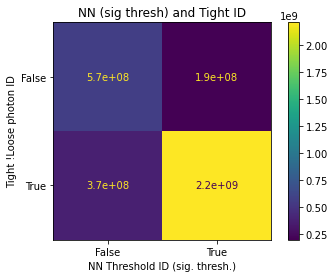

In [39]:
## do four bin 2dhistogram
#separate by sig/bkg?

##  NN (sig thresh) vs tight ID

loose = df_all.y_IsLoose.ravel()

weight = df_all.finalWeight.ravel()[loose]

x = df_all.y_pred_test.ravel() > sig_thresh
x = x[loose]*1
y = df_all.y_IsTight[loose]*1

# heatmap, xedges, yedges = np.histogram2d(x, y, bins=[2,2], weights=df_all.finalWeight.ravel()[loose])
# extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

# plt.clf()
# plt.imshow(heatmap.T, origin='lower')#, norm=colors.LogNorm(vmin=4e8))#,extent=extent)

# cb = plt.colorbar()
# cb.set_label('weighted count') 

# plt.title('NN and Tight ID')
# plt.xlabel('NN Threshold ID (wrong scale)')
# plt.ylabel('TightID (wrong scale)')
# plt.show()

matrix = confusion_matrix(y, x,sample_weight=weight)  #first is y axis, second is x axis

disp = ConfusionMatrixDisplay(confusion_matrix=matrix,display_labels=['False', 'True'])

disp.plot()
plt.ylabel('Tight !Loose photon ID')
plt.xlabel('NN Threshold ID (sig. thresh.)')
# plt.imshow(norm=colors.LogNorm())
# cb=plt.colorbar()
# cb.set_label('weighted count')
plt.title('NN (sig thresh) and Tight ID')
plt.savefig('plots/NN_TightID/'+version+conv+'_'+size+standstr+'_sigthresh.png',dpi=360,format='png')

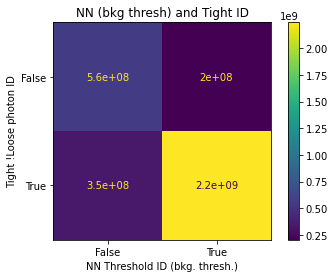

In [40]:
##  NN (bkg thresh) vs tight ID

loose = df_all.y_IsLoose.ravel()

weight = df_all.finalWeight.ravel()[loose]

x = df_all.y_pred_test.ravel() > bkg_thresh
x = x[loose]*1
y = df_all.y_IsTight[loose]*1

# heatmap, xedges, yedges = np.histogram2d(x, y, bins=[2,2], weights=df_all.finalWeight.ravel()[loose])
# extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

# plt.clf()
# plt.imshow(heatmap.T, origin='lower')#, norm=colors.LogNorm(vmin=4e8))#,extent=extent)

# cb = plt.colorbar()
# cb.set_label('weighted count') 

# plt.title('NN and Tight ID')
# plt.xlabel('NN Threshold ID (wrong scale)')
# plt.ylabel('TightID (wrong scale)')
# plt.show()

matrix = confusion_matrix(y, x,sample_weight=weight)  #first is y axis, second is x axis

disp = ConfusionMatrixDisplay(confusion_matrix=matrix,display_labels=['False', 'True'])

disp.plot()
plt.ylabel('Tight !Loose photon ID')
plt.xlabel('NN Threshold ID (bkg. thresh.)')
# plt.imshow(norm=colors.LogNorm())
# cb=plt.colorbar()
# cb.set_label('weighted count')
plt.title('NN (bkg thresh) and Tight ID')
plt.savefig('plots/NN_TightID/'+version+conv+'_'+size+standstr+'_bkgthresh.png',dpi=360,format='png')

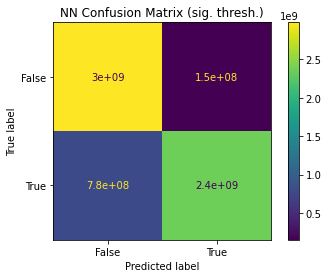

In [41]:
### NN CONFUSION MATRIX:
#(sig thresh)

weight = df_all.finalWeight.ravel()
x = df_all.y_pred_test.ravel() > sig_thresh
y = df_all.y_isTruthMatchedPhoton.ravel()

matrix = confusion_matrix(y, x,sample_weight=weight)  #first is y axis, second is x axis

disp = ConfusionMatrixDisplay(confusion_matrix=matrix,display_labels=['False', 'True'])
disp.plot()
plt.title('NN Confusion Matrix (sig. thresh.)')
plt.savefig('plots/confusion/'+version+conv+'_'+size+standstr+'_confsig.png',dpi=360,format='png')

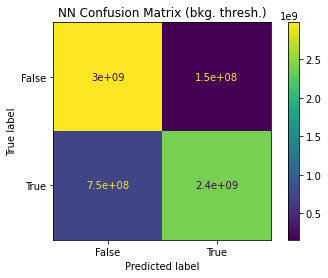

In [42]:
### NN CONFUSION MATRIX:
#(bkg thresh)

weight = df_all.finalWeight.ravel()
x = df_all.y_pred_test.ravel() > bkg_thresh
y = df_all.y_isTruthMatchedPhoton.ravel()

matrix = confusion_matrix(y, x,sample_weight=weight)  #first is y axis, second is x axis

disp = ConfusionMatrixDisplay(confusion_matrix=matrix,display_labels=['False', 'True'])
disp.plot()
plt.title('NN Confusion Matrix (bkg. thresh.)')
plt.savefig('plots/confusion/'+version+conv+'_'+size+standstr+'_confbkg.png',dpi=360,format='png')

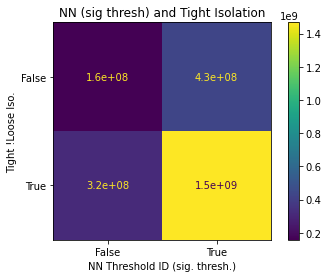

In [43]:
##  NN (sig thresh) vs tight isolation

loose = df_all.y_iso_FixedCutLoose.ravel()

weight = df_all.finalWeight.ravel()[loose]

x = df_all.y_pred_test.ravel() > sig_thresh
x = x[loose]*1
y = df_all.y_iso_FixedCutTight[loose]*1

# heatmap, xedges, yedges = np.histogram2d(x, y, bins=[2,2], weights=df_all.finalWeight.ravel()[loose])
# extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

# plt.clf()
# plt.imshow(heatmap.T, origin='lower')#, norm=colors.LogNorm(vmin=4e8))#,extent=extent)

# cb = plt.colorbar()
# cb.set_label('weighted count') 

# plt.title('NN and Tight ID')
# plt.xlabel('NN Threshold ID (wrong scale)')
# plt.ylabel('TightID (wrong scale)')
# plt.show()

matrix = confusion_matrix(y, x,sample_weight=weight)  #first is y axis, second is x axis

disp = ConfusionMatrixDisplay(confusion_matrix=matrix,display_labels=['False', 'True'])

disp.plot()
plt.ylabel('Tight !Loose Iso.')
plt.xlabel('NN Threshold ID (sig. thresh.)')
# plt.imshow(norm=colors.LogNorm())
# cb=plt.colorbar()
# cb.set_label('weighted count')
plt.title('NN (sig thresh) and Tight Isolation')
plt.savefig('plots/iso/'+version+conv+'_'+size+standstr+'_isoNNsig.png',dpi=360,format='png')

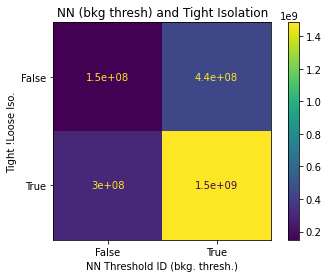

In [44]:
##  NN (bkg thresh) vs tight isolation

loose = df_all.y_iso_FixedCutLoose.ravel()

weight = df_all.finalWeight.ravel()[loose]

x = df_all.y_pred_test.ravel() > bkg_thresh
x = x[loose]*1
y = df_all.y_iso_FixedCutTight[loose]*1

# heatmap, xedges, yedges = np.histogram2d(x, y, bins=[2,2], weights=df_all.finalWeight.ravel()[loose])
# extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

# plt.clf()
# plt.imshow(heatmap.T, origin='lower')#, norm=colors.LogNorm(vmin=4e8))#,extent=extent)

# cb = plt.colorbar()
# cb.set_label('weighted count') 

# plt.title('NN and Tight ID')
# plt.xlabel('NN Threshold ID (wrong scale)')
# plt.ylabel('TightID (wrong scale)')
# plt.show()

matrix = confusion_matrix(y, x,sample_weight=weight)  #first is y axis, second is x axis

disp = ConfusionMatrixDisplay(confusion_matrix=matrix,display_labels=['False', 'True'])

disp.plot()
plt.ylabel('Tight !Loose Iso.')
plt.xlabel('NN Threshold ID (bkg. thresh.)')
# plt.imshow(norm=colors.LogNorm())
# cb=plt.colorbar()
# cb.set_label('weighted count')
plt.title('NN (bkg thresh) and Tight Isolation')
plt.savefig('plots/iso/'+version+conv+'_'+size+standstr+'_isoNNbkg.png',dpi=360,format='png')

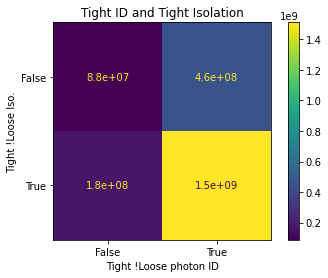

In [45]:
##  Tight ID vs tight isolation

loose = df_all.y_iso_FixedCutLoose.ravel() & df_all.y_IsLoose.ravel()

weight = df_all.finalWeight.ravel()[loose]

x = df_all.y_IsTight.ravel()[loose]*1

y = df_all.y_iso_FixedCutTight[loose]*1

# heatmap, xedges, yedges = np.histogram2d(x, y, bins=[2,2], weights=df_all.finalWeight.ravel()[loose])
# extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

# plt.clf()
# plt.imshow(heatmap.T, origin='lower')#, norm=colors.LogNorm(vmin=4e8))#,extent=extent)

# cb = plt.colorbar()
# cb.set_label('weighted count') 

# plt.title('NN and Tight ID')
# plt.xlabel('NN Threshold ID (wrong scale)')
# plt.ylabel('TightID (wrong scale)')
# plt.show()

matrix = confusion_matrix(y, x,sample_weight=weight)  #first is y axis, second is x axis

disp = ConfusionMatrixDisplay(confusion_matrix=matrix,display_labels=['False', 'True'])

disp.plot()
plt.ylabel('Tight !Loose Iso.')
plt.xlabel('Tight !Loose photon ID')
# plt.imshow(norm=colors.LogNorm())
# cb=plt.colorbar()
# cb.set_label('weighted count')
plt.title('Tight ID and Tight Isolation')
plt.savefig('plots/iso/'+version+conv+'_'+size+standstr+'_isoTightID.png',dpi=360,format='png')

In [91]:
def averageNNplot(df,y_pred,variable,binedges,log=False,variablelabel=False,dflabel='',minn=0,figname=False,xlabel='xlabel'):
    
    if variablelabel == False:
        variablelabel = variable
    if minn > 0:
        minn = 0
    
    NNbinedges = binedges
    binvals = []
    
    for i in range(len(NNbinedges)-1):
        boolmask = (y_pred >= NNbinedges[i]) & (y_pred < NNbinedges[i+1])
        variablelist = np.array(df[variable][boolmask])
        weightlist = np.array(df['finalWeight'][boolmask])
        if abs(sum(weightlist)) > 1e-9:
            average = np.average(variablelist,weights=weightlist)
        else:
            average = 0
        binvals.append(average)

    leftedge = NNbinedges[:-1]
    width = np.diff(NNbinedges)
    plt.bar(leftedge,binvals,width,align='edge',edgecolor='k')
    plt.grid(alpha=0.4)
    plt.xlabel(xlabel);plt.ylabel(r'Weighted Average '+variablelabel)
    plt.title(r'Average NN score as a function of '+xlabel+'\n'+dflabel)
    plt.ylim((0,1))
    if log==True:
        plt.xscale('log')
    if bool(figname)==True:
        plt.savefig(figname+'.png',dpi=360,format='png')
    plt.show()
    plt.close()

In [121]:

binedgesETA = [0,0.6,0.8,1.15,1.37,1.52,1.81,2.01,2.37]
binedgesET = [0,25,30,35,40,45,50,60,80,100,120,200,500,5000]


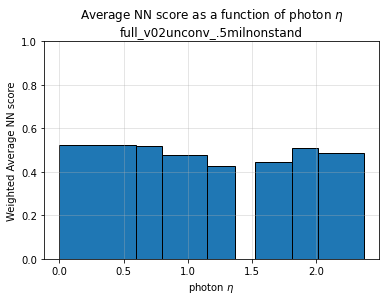

In [137]:
averageNNplot(df_all,df_all.y_eta.ravel(),'y_pred_test',binedgesETA,variablelabel='NN score',dflabel=version+conv+'_'+size+standstr,xlabel=r'photon $\eta$',figname='plots/averageNN/'+version+conv+'_'+size+standstr+'_avgNNeta')

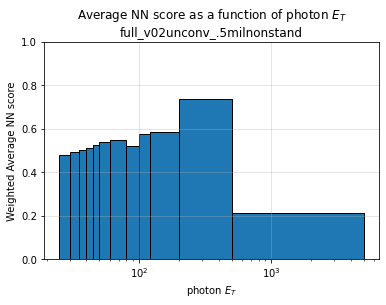

In [138]:
averageNNplot(df_all,df_all.y_pt.ravel(),'y_pred_test',binedgesET,log=True,variablelabel='NN score',dflabel=version+conv+'_'+size+standstr,xlabel=r'photon $E_T$',figname='plots/averageNN/'+version+conv+'_'+size+standstr+'_avgNNet')